In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.fftpack as ff
from quantities import Hz
import neuron
import LFPy
from brainsignals.plotting_convention import mark_subplots
import brainsignals.neural_simulations as ns

ns.load_mechs_from_folder(ns.cell_models_folder)
np.random.seed(1534)

Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models.  Aborting.


In [2]:
# sigma = 0.3
cut_off = 200
tstop = 2**12 + cut_off
dt = 2**-6

rate = 5000 * Hz
     
def make_white_noise_stimuli(cell, input_idx, freqs, tvec, input_scaling=0.005):

    I = np.zeros(len(tvec))

    for freq in freqs:
        I += np.sin(2 * np.pi * freq * tvec/1000. + 2*np.pi*np.random.random())    
    input_array = input_scaling * I

    noise_vec = neuron.h.Vector(input_array)

    i = 0
    syn = None
    for sec in cell.allseclist:
        for seg in sec:
            if i == input_idx:
                print("Input inserted in ", sec.name())
                syn = neuron.h.ISyn(seg.x, sec=sec)
            i += 1
    if syn is None:
        raise RuntimeError("Wrong stimuli index")
    syn.dur = 1E9
    syn.delay = 0
    noise_vec.play(syn._ref_amp, cell.dt)
    return cell, syn, noise_vec        

## Cell models functions

In [3]:
import os
from os.path import join
from glob import glob

h = neuron.h

real_cells_folder = '/Users/susannedahle/Python/brainsignals/cell_models/bbp_models'
bbp_folder = os.path.abspath(real_cells_folder)

cell_models_folder = '/Users/susannedahle/Python/brainsignals/cell_models'
bbp_mod_folder = join(cell_models_folder, "bbp_mod")

In [6]:
# Real neuron model
def return_BBP_neuron(cell_name, tstop, dt):

    # load some required neuron-interface files
    neuron.h.load_file("stdrun.hoc")
    neuron.h.load_file("import3d.hoc")

    CWD = os.getcwd()
    cell_folder = join(join(bbp_folder, cell_name))
    if not os.path.isdir(cell_folder):
        ns.download_BBP_model(cell_name)

    neuron.load_mechanisms(bbp_mod_folder)
    os.chdir(cell_folder)
    add_synapses = False
    # get the template name
    f = open("template.hoc", 'r')
    templatename = ns.get_templatename(f)
    f.close()

    # get biophys template name
    f = open("biophysics.hoc", 'r')
    biophysics = ns.get_templatename(f)
    f.close()

    # get morphology template name
    f = open("morphology.hoc", 'r')
    morphology = ns.get_templatename(f)
    f.close()

    # get synapses template name
    f = open(ns.posixpth(os.path.join("synapses", "synapses.hoc")), 'r')
    synapses = ns.get_templatename(f)
    f.close()

    neuron.h.load_file('constants.hoc')

    if not hasattr(neuron.h, morphology):
        """Create the cell model"""
        # Load morphology
        neuron.h.load_file(1, "morphology.hoc")
    if not hasattr(neuron.h, biophysics):
        # Load biophysics
        neuron.h.load_file(1, "biophysics.hoc")
    if not hasattr(neuron.h, synapses):
        # load synapses
        neuron.h.load_file(1, ns.posixpth(os.path.join('synapses', 'synapses.hoc')
                                       ))
    if not hasattr(neuron.h, templatename):
        # Load main cell template
        neuron.h.load_file(1, "template.hoc")

    templatefile = ns.posixpth(os.path.join(cell_folder, 'template.hoc'))

    morphologyfile = glob(os.path.join('morphology', '*'))[0]


    # Instantiate the cell(s) using LFPy
    cell = LFPy.TemplateCell(morphology=morphologyfile,
                             templatefile=templatefile,
                             templatename=templatename,
                             templateargs=1 if add_synapses else 0,
                             tstop=tstop,
                             dt=dt,
                             lambda_f = 500,
                             nsegs_method='lambda_f',
                             v_init = -65)
    os.chdir(CWD)
    # set view as in most other examples
    cell.set_rotation(x=np.pi / 2)
    return cell

## White noise

In [10]:
cut_off = 2000
tstop = 5000. + cut_off
dt = 2**-4

rate = 5000 * Hz

cell_types = {
    "L5_MC_bAC217_1": "L5 Martinotti cell",
    "L5_TTPC2_cADpyr232_2": "L5 Pyramidal cell",
    "L5_NGC_bNAC219_5": "L5 Neurogliaform cell"
}

remove_list = ["Ca_HVA", "Ca_LVAst", "Ca", "CaDynamics_E2", 
                "Ih", "Im", "K_Pst", "K_Tst", "KdShu2007", "Nap_Et2",
                "NaTa_t", "NaTs2_t", "SK_E2", "SKv3_1", "StochKv"]

cdm_amp_dict = {}  # To store amplitude spectra for each cell
imem_amp_dict = {}

# Common setup
num_tsteps = int(tstop / dt + 1)
tvec = np.arange(num_tsteps) * dt
t0_idx = np.argmin(np.abs(tvec - cut_off))

sample_freq = ff.fftfreq(num_tsteps - t0_idx, d=dt / 1000)
pidxs = np.where(sample_freq >= 0)
freqs = sample_freq[pidxs]

# Loop over each cell type
for cell_name, label in cell_types.items():
    cell = return_BBP_neuron(cell_name, tstop=tstop, dt=dt)
    
    # Insert noise
    cell, syn, noise_vec = make_white_noise_stimuli(cell, input_idx=0, freqs=freqs[freqs < 2020], tvec=tvec)
    ns.remove_active_mechanisms(remove_list, cell)

    # Run simulation
    cell.simulate(rec_imem=True, rec_vmem=True)

    # Cut initial segment
    cell.vmem = cell.vmem[:, t0_idx:]
    cell.imem = cell.imem[:, t0_idx:]
    cell.tvec = cell.tvec[t0_idx:] - cell.tvec[t0_idx]

    # Compute dipole moment (z-component)
    cdm = LFPy.CurrentDipoleMoment(cell).get_transformation_matrix() @ cell.imem
    cdm = cdm[2, :]

    # Get frequency and amplitude of cdm
    freqs_s, amp_cdm_s = ns.return_freq_and_amplitude(cell.tvec, cdm)

    # Store amplitude spectrum (normalized)
    # cdm_amp_dict[label] = (freqs_s, amp_cdm_s[0, :] / amp_cdm_s[0, 1])
    cdm_amp_dict[label] = (freqs_s, amp_cdm_s[0, :])

    # Store imem amplitudes at 10, 100, 1000 Hz
    imem_amplitudes_at_freqs = []
    target_freqs = [10, 100, 1000]

    for idx in range(cell.totnsegs):
        imem_seg = cell.imem[idx, :]
        freqs_imem, imem_amps = ns.return_freq_and_amplitude(cell.tvec, imem_seg)

        # Extract amplitudes for the target frequencies
        segment_amplitudes = []
        for f in target_freqs:
            freq_idx = np.argmin(np.abs(freqs_imem - f))
            amplitude = imem_amps[0, freq_idx]
            segment_amplitudes.append(amplitude)

        imem_amplitudes_at_freqs.append(segment_amplitudes)

    # Store in dictionary
    imem_amp_dict[label] = {
        'freqs': target_freqs,
        'x': cell.x.tolist(),
        'z': cell.z.tolist(),
        'totnsegs': cell.totnsegs,
        'tvec': cell.tvec.tolist(),
        'imem_amps': imem_amplitudes_at_freqs,  # Shape: (totnsegs, len(target_freqs))
    }

    del cell, cdm, freqs_s, amp_cdm_s


Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
Input inserted in  bAC217_L5_MC_cc2a170ef6[0].soma[0]
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
	1 
	1 
	1 
Input inserted in  cADpyr232_L5_TTPC2_a28017c6c7[0].soma[0]
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
	1 
	1 
	1 
Input inserted in  bNAC219_L5_NGC_c05e76271c[0].soma[0]


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.gridspec as gridspec

def plot_scatter_sum_imem_vs_z_white_noise_broken_x(imem_amp_dict, selected_cells=None,
                                                     xlim1=(0, 0.00025), xlim2=(0.002, None)):
    unique_cells = list(imem_amp_dict.keys())
    if selected_cells:
        unique_cells = [cell for cell in unique_cells if cell in selected_cells]

    num_cells = len(unique_cells)

    fig = plt.figure(figsize=(6, 3 * num_cells))
    gs = gridspec.GridSpec(num_cells, 3, figure=fig, width_ratios=[1, 1.2, 1.2], wspace=0.2, hspace=0.4)

    axs = {}

    for i, label in enumerate(unique_cells):
        axs[label] = {
            'morph': fig.add_subplot(gs[i, 0]),
            'imem_left': fig.add_subplot(gs[i, 1]),
            'imem_right': fig.add_subplot(gs[i, 2], sharey=fig.axes[-1] if i > 0 else None),
        }

    for label, ax_dict in axs.items():
        cell_data = imem_amp_dict[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        freqs = np.array(cell_data['freqs'])
        imem_amps = np.array(cell_data['imem_amps'])
        z_coords = z.mean(axis=-1)

        # -- Morphology plot
        ax1 = ax_dict['morph']
        for idx in range(totnsegs):
            ax1.plot(x[idx], z[idx], c='black', lw=1)
        ax1.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='red', label="Soma", markersize=2)
        ax1.set_title(f'{label}')
        ax1.set_xlabel('x [µm]')
        ax1.set_ylabel('z [µm]')
        ax1.set_aspect('equal')
        ax1.legend(loc='best', fontsize = 'x-small')

        # -- Imem scatter plots
        ax_left = ax_dict['imem_left']
        ax_right = ax_dict['imem_right']
        colors = ['tab:purple', 'tab:orange', 'tab:green']

        for f_idx, f in enumerate(freqs):
            z_imem_map = defaultdict(float)
            for seg_idx in range(totnsegs):
                z_imem_map[z_coords[seg_idx]] += imem_amps[seg_idx][f_idx]

            z_vals = list(z_imem_map.keys())
            imem_vals = list(z_imem_map.values())
            if f == 10:
                alpha = 0.8
                marker = 'o'
                markersize = 20
            elif f == 100:
                alpha = 0.8
                marker = 'x'
                markersize = 10
            else:
                alpha = 0.5
                marker = '^'
                markersize = 10
            ax_left.scatter(imem_vals, z_vals, label=f'{f} Hz', alpha=alpha, marker = marker, color = colors[f_idx], s = markersize)
            ax_right.scatter(imem_vals, z_vals, label=f'{f} Hz', alpha=0.7, marker = marker, color = colors[f_idx], s = markersize)

        # Set x-limits
        ax_left.set_xlim(xlim1)
        if xlim2[1] is None:
            xmax = max([max(v) for v in imem_amps.T])
            ax_right.set_xlim((xlim2[0], xmax+0.0001))
        else:
            ax_right.set_xlim(xlim2)

        # Hide spines between broken axes
        ax_left.spines['right'].set_visible(False)
        ax_right.spines['left'].set_visible(False)
        ax_left.yaxis.tick_left()
        ax_right.yaxis.tick_right()
        ax_right.yaxis.set_label_position('right')

        for ax in [ax_left, ax_right]:
            for label in ax.get_xticklabels():
                label.set_rotation(45)
            ax.tick_params(axis='x', labelrotation=45)

        # Add break markers (diagonal slashes)
        d = .015  # size of diagonal lines
        kwargs = dict(transform=ax_left.transAxes, color='k', clip_on=False)
        ax_left.plot([1 - d, 1 + d], [-d, +d], **kwargs)
        ax_left.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

        kwargs.update(transform=ax_right.transAxes)
        ax_right.plot([-d, +d], [-d, +d], **kwargs)
        ax_right.plot([-d, +d], [1 - d, 1 + d], **kwargs)

        # Set shared labels and legends
        ax_right.set_ylabel('z [µm]')
        #ax_left.set_title('Imem amplitude vs z (broken x-axis)')
        ax_right.legend(loc='best')

    fig.text(0.62, 0.04, r'Sum of $I_{mem}$ amplitudes [nA]', ha='center', fontsize=10)
    plt.tight_layout()
    plt.savefig('Imem_scatter_broken_x.png')
    plt.show()


/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_40194/236023389.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


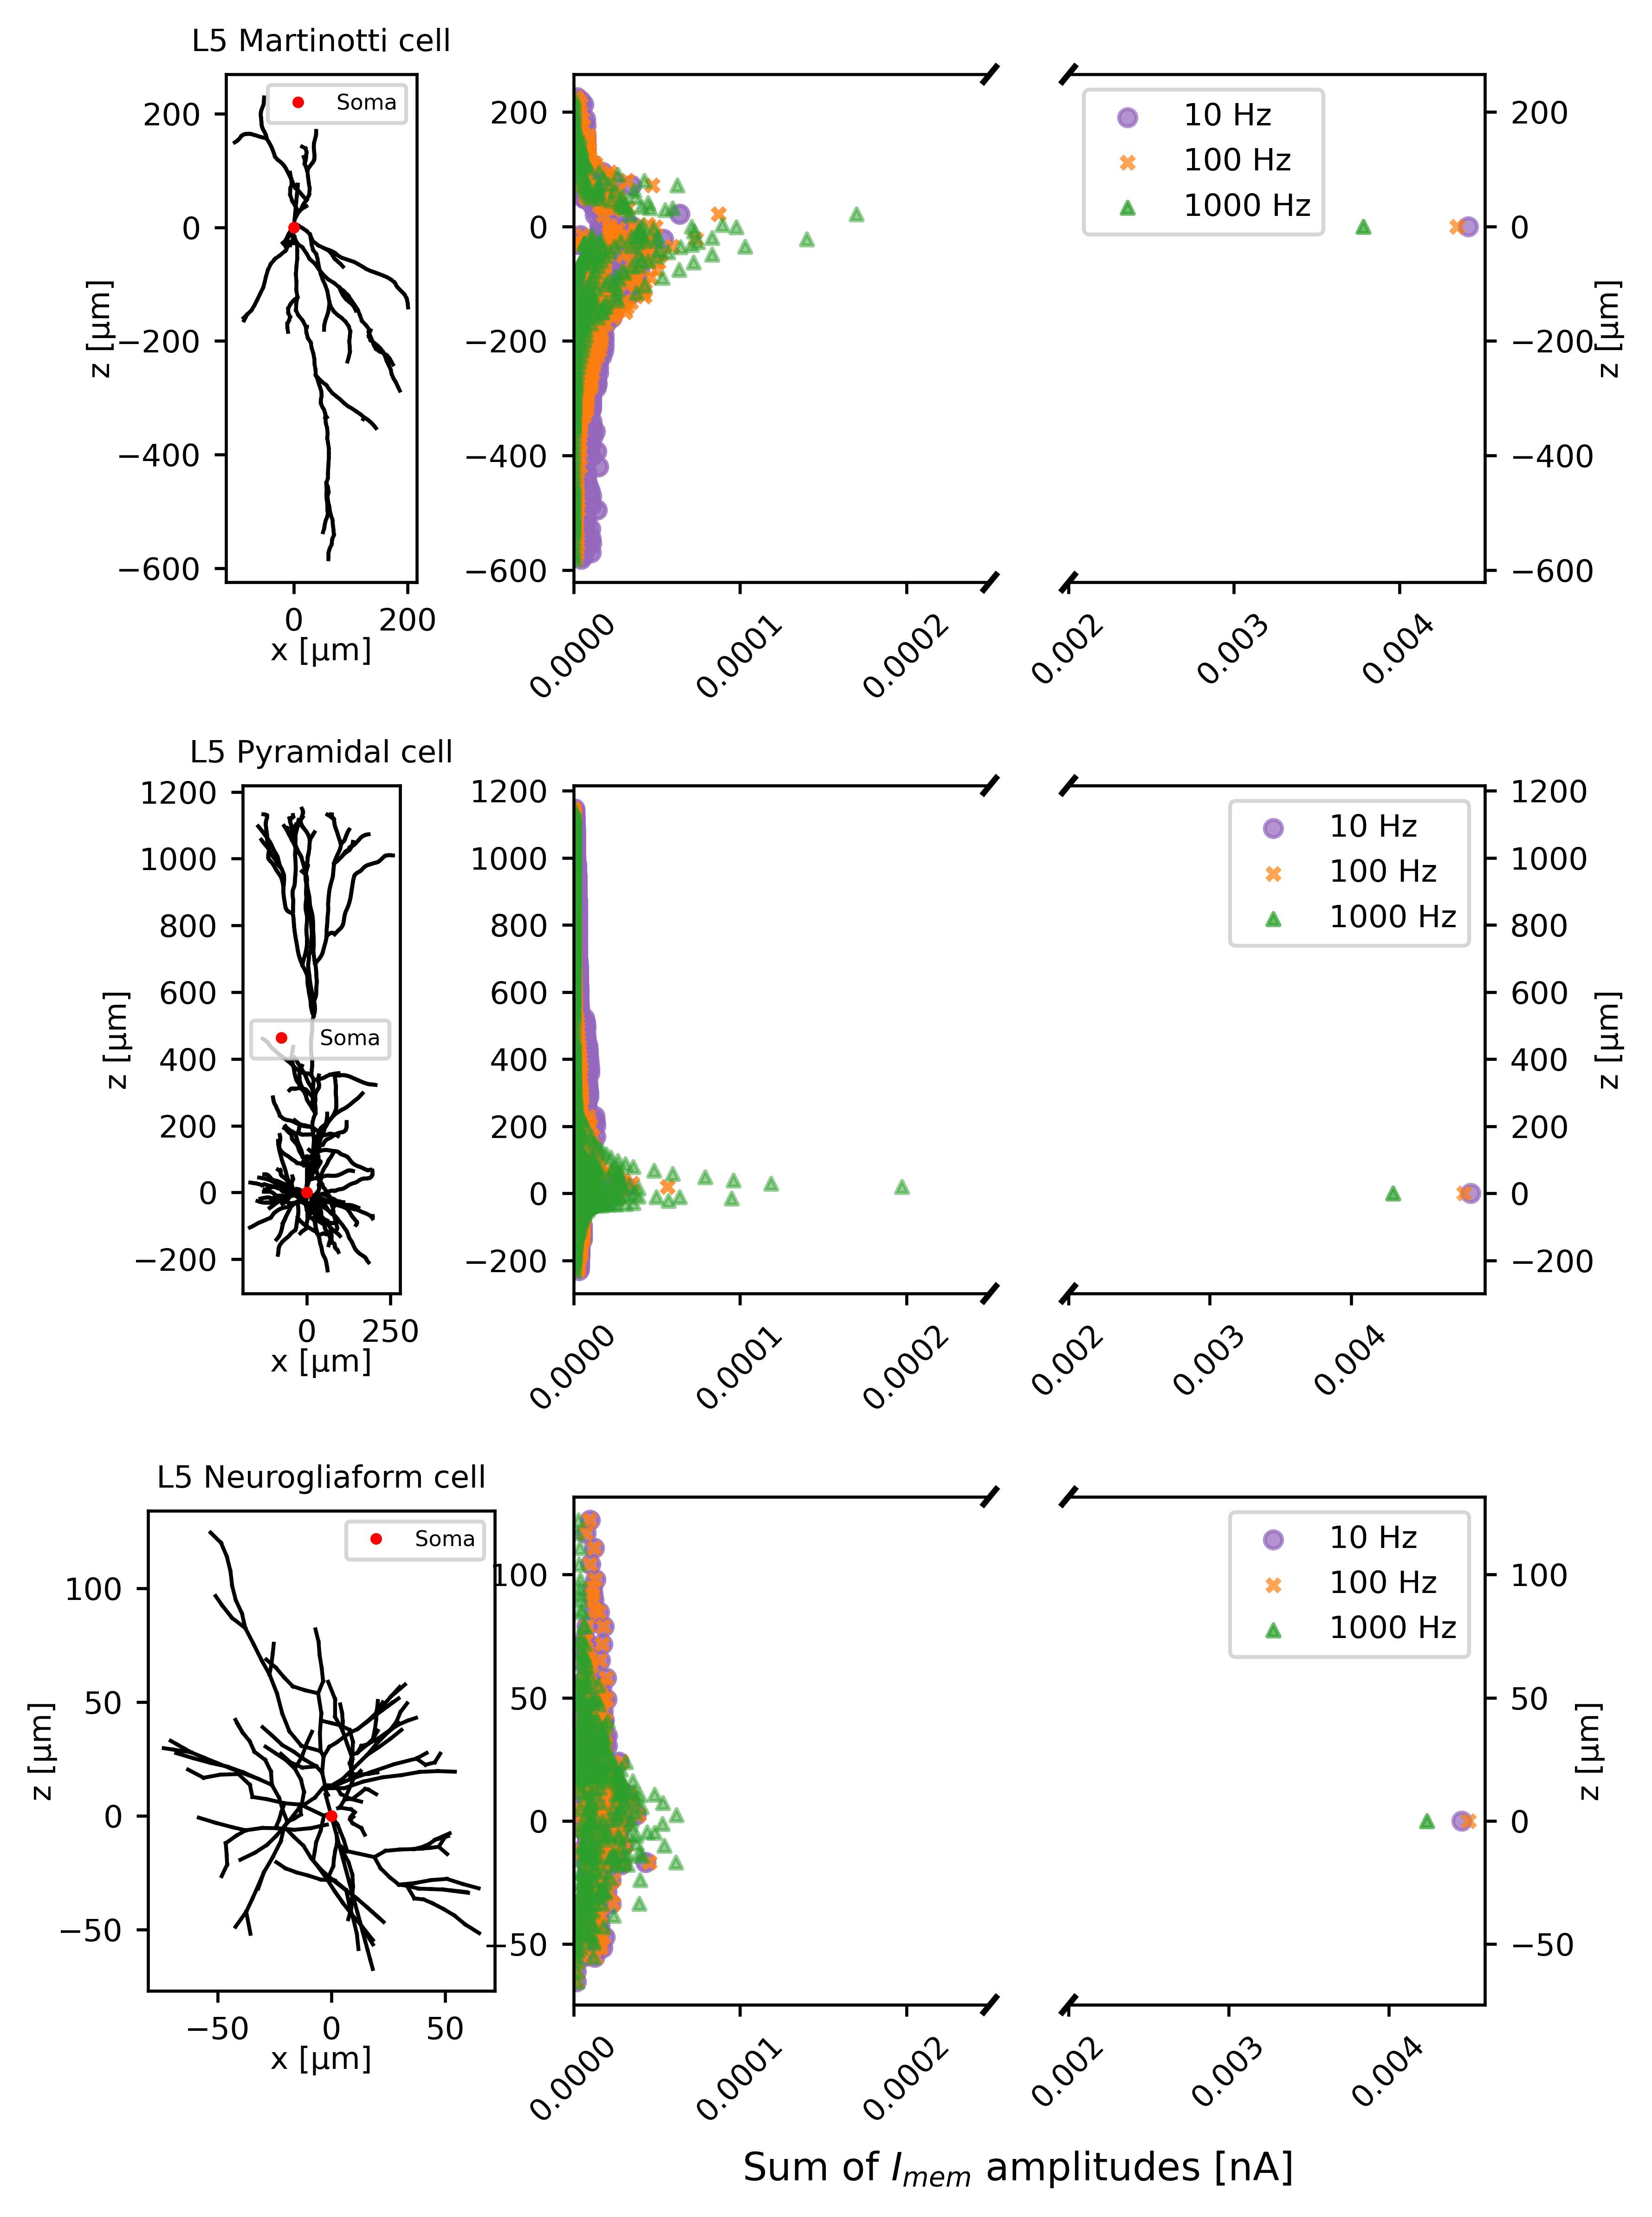

In [13]:
plot_scatter_sum_imem_vs_z_white_noise_broken_x(imem_amp_dict, selected_cells=None)

## Extracellular

In [18]:
soma_amp_dict = {} 
plot_data_dict_ex = {}


# List of active mechanisms to remove to make passive
remove_list = ["Ca_HVA", "Ca_LVAst", "Ca", "CaDynamics_E2", 
            "Ih", "Im", "K_Pst", "K_Tst", "KdShu2007", "Nap_Et2",
            "NaTa_t", "NaTs2_t", "SK_E2", "SKv3_1", "StochKv"]


# Simulation time 
tstop = 5000.
dt = 2**-4

cutoff = 20

# El field frequency 
freq1 = np.arange(1, 10, 1) # Shorter steplength in beginning
freq2 = np.arange(10, 100, 10)
freq3 = np.arange(100, 2200, 200) # Longer steplength to save calculation time
freq = sorted(np.concatenate((freq1, freq2, freq3, np.array([1000]))))

# El field strengths 
local_E_field = 1  # V/m

local_ext_pot = np.vectorize(lambda x, y, z: local_E_field * z / 1000)
n_tsteps_ = int((tstop + cutoff) / dt + 1)
t_ = np.arange(n_tsteps_) * dt

for cell_name, label in cell_types.items():
    print(cell_name)
    ns.compile_bbp_mechanisms(cell_name)

    for f in freq:
        
        cell = return_BBP_neuron(cell_name, tstop, dt)
        ns.remove_active_mechanisms(remove_list, cell)
    
        cell.extracellular = True

        for sec in cell.allseclist:
            sec.insert("extracellular")

        # Calculate and insert extracellular potential
        base_pot = local_ext_pot(
            cell.x.mean(axis=-1),
            cell.y.mean(axis=-1),
            cell.z.mean(axis=-1)
        ).reshape(cell.totnsegs, 1)

        pulse = np.sin(2 * np.pi * f * t_ / 1000)

        v_cell_ext = np.zeros((cell.totnsegs, n_tsteps_))
        v_cell_ext = base_pot * pulse.reshape(1, n_tsteps_)

        cell.insert_v_ext(v_cell_ext, t_)
        cell.simulate(rec_vmem=True, rec_imem=True)

        # Calculate soma amp with fourier
        cut_tvec = cell.tvec[cell.tvec > 2000]
        cut_soma_vmem = cell.vmem[0, cell.tvec > 2000]
        freqs, vmem_amps = ns.return_freq_and_amplitude(cut_tvec, cut_soma_vmem)
        freq_idx = np.argmin(np.abs(freqs - f))
        soma_amp = vmem_amps[0, freq_idx]

        # Write data to .npy file
        if label not in soma_amp_dict:
            soma_amp_dict[label] = {
                'freq': [],
                'soma_vmem_amp': []
            }
        soma_amp_dict[label]['freq'].append(f)
        soma_amp_dict[label]['soma_vmem_amp'].append(soma_amp)

        if f in [10, 100, 1000]:
            # Calculate amplitude in all segments by removing the part before the cell stabilizes 
            vmem_amplitudes = []
            for idx in range(cell.totnsegs):
                cut_tvec = cell.tvec[cell.tvec > 2000]
                cut_vmem = cell.vmem[idx, cell.tvec > 2000]
                freqs, vmem_amps = ns.return_freq_and_amplitude(cut_tvec, cut_vmem)
                freq_idx = np.argmin(np.abs(freqs - f))
                amplitude = vmem_amps[0, freq_idx]
                vmem_amplitudes.append(amplitude)

            imem_amplitudes = []
            for idx in range(cell.totnsegs):
                cut_tvec = cell.tvec[cell.tvec > 2000]
                cut_imem = cell.imem[idx, cell.tvec > 2000]
                freqs, imem_amps = ns.return_freq_and_amplitude(cut_tvec, cut_imem)
                freq_idx = np.argmin(np.abs(freqs - f))
                amplitude = imem_amps[0, freq_idx]
                imem_amplitudes.append(amplitude)

            # Save plot-data in a .npy file
            if label not in plot_data_dict_ex:
                plot_data_dict_ex[label] = {
                    'freq': [],
                    "x": cell.x.tolist(),
                    "z": cell.z.tolist(),
                    "totnsegs": cell.totnsegs,
                    "tvec": cell.tvec.tolist(),
                    "soma_vmem": [],
                    "vmem_amps": [],
                    "imem_amps": [],
                }

            plot_data_dict_ex[label]['freq'].append(f)
            plot_data_dict_ex[label]['soma_vmem'].append(cell.vmem[0].tolist())
            plot_data_dict_ex[label]['vmem_amps'].append(vmem_amplitudes)
            plot_data_dict_ex[label]['imem_amps'].append(imem_amplitudes)
            
        del cell

        print(f"{f} Hz complete for {cell_name}")

L5_MC_bAC217_1


/opt/anaconda3/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/usr/bin/xcrun
/Users/susannedahle/Python/brainsignals/cell_models/bbp_mod
Mod files: "./Ca.mod" "./CaDynamics_E2.mod" "./Ca_HVA.mod" "./Ca_LVAst.mod" "./Ih.mod" "./Im.mod" "./K_Pst.mod" "./K_Tst.mod" "./KdShu2007.mod" "./NaTa_t.mod" "./NaTs2_t.mod" "./Nap_Et2.mod" "./ProbAMPANMDA_EMS.mod" "./ProbGABAAB_EMS.mod" "./SK_E2.mod" "./SKv3_1.mod" "./StochKv.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib


clang: error: unable to execute command: Bus error: 10
clang: error: linker command failed due to signal (use -v to see invocation)
make: *** [mech_lib_shared] Error 1
Traceback (most recent call last):
  File "/opt/anaconda3/bin/nrnivmodl", line 114, in <module>
    subprocess.check_call([exe, *sys.argv[1:]])
  File "/opt/anaconda3/lib/python3.12/subprocess.py", line 413, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['/opt/anaconda3/lib/python3.12/site-packages/neuron/.data/bin/nrnivmodl']' returned non-zero exit status 2.


Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
1 Hz complete for L5_MC_bAC217_1
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
2 Hz complete for L5_MC_bAC217_1
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
3 Hz complete for L5_MC_bAC217_1
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
4 Hz complete for L5_MC_bAC217_1
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
5 Hz complete for L5_MC_bAC217_1
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
6 Hz complete for L5_MC_bAC217_1
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
7 Hz complete for L5_MC_bAC217_1
Mechan

/opt/anaconda3/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/usr/bin/xcrun
/Users/susannedahle/Python/brainsignals/cell_models/bbp_mod
Mod files: "./Ca.mod" "./CaDynamics_E2.mod" "./Ca_HVA.mod" "./Ca_LVAst.mod" "./Ih.mod" "./Im.mod" "./K_Pst.mod" "./K_Tst.mod" "./KdShu2007.mod" "./NaTa_t.mod" "./NaTs2_t.mod" "./Nap_Et2.mod" "./ProbAMPANMDA_EMS.mod" "./ProbGABAAB_EMS.mod" "./SK_E2.mod" "./SKv3_1.mod" "./StochKv.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.


clang: error: unable to execute command: Bus error: 10
clang: error: linker command failed due to signal (use -v to see invocation)
make: *** [mech_lib_shared] Error 1
Traceback (most recent call last):
  File "/opt/anaconda3/bin/nrnivmodl", line 114, in <module>
    subprocess.check_call([exe, *sys.argv[1:]])
  File "/opt/anaconda3/lib/python3.12/subprocess.py", line 413, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['/opt/anaconda3/lib/python3.12/site-packages/neuron/.data/bin/nrnivmodl']' returned non-zero exit status 2.


1 Hz complete for L5_TTPC2_cADpyr232_2
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
2 Hz complete for L5_TTPC2_cADpyr232_2
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
3 Hz complete for L5_TTPC2_cADpyr232_2
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
4 Hz complete for L5_TTPC2_cADpyr232_2
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
5 Hz complete for L5_TTPC2_cADpyr232_2
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
6 Hz complete for L5_TTPC2_cADpyr232_2
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
7 Hz complete for L5_TTPC2_cADpyr232_2
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsign

/opt/anaconda3/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/usr/bin/xcrun
/Users/susannedahle/Python/brainsignals/cell_models/bbp_mod
Mod files: "./Ca.mod" "./CaDynamics_E2.mod" "./Ca_HVA.mod" "./Ca_LVAst.mod" "./Ih.mod" "./Im.mod" "./K_Pst.mod" "./K_Tst.mod" "./KdShu2007.mod" "./NaTa_t.mod" "./NaTs2_t.mod" "./Nap_Et2.mod" "./ProbAMPANMDA_EMS.mod" "./ProbGABAAB_EMS.mod" "./SK_E2.mod" "./SKv3_1.mod" "./StochKv.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib


clang: error: unable to execute command: Bus error: 10
clang: error: linker command failed due to signal (use -v to see invocation)
make: *** [mech_lib_shared] Error 1
Traceback (most recent call last):
  File "/opt/anaconda3/bin/nrnivmodl", line 114, in <module>
    subprocess.check_call([exe, *sys.argv[1:]])
  File "/opt/anaconda3/lib/python3.12/subprocess.py", line 413, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['/opt/anaconda3/lib/python3.12/site-packages/neuron/.data/bin/nrnivmodl']' returned non-zero exit status 2.


Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
1 Hz complete for L5_NGC_bNAC219_5
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
2 Hz complete for L5_NGC_bNAC219_5
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
3 Hz complete for L5_NGC_bNAC219_5
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
4 Hz complete for L5_NGC_bNAC219_5
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
5 Hz complete for L5_NGC_bNAC219_5
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
6 Hz complete for L5_NGC_bNAC219_5
Mechanisms already loaded from path: /Users/susannedahle/Python/brainsignals/cell_models/bbp_mod.  Aborting.
7 Hz complete for L5_NGC_bN

# Plot

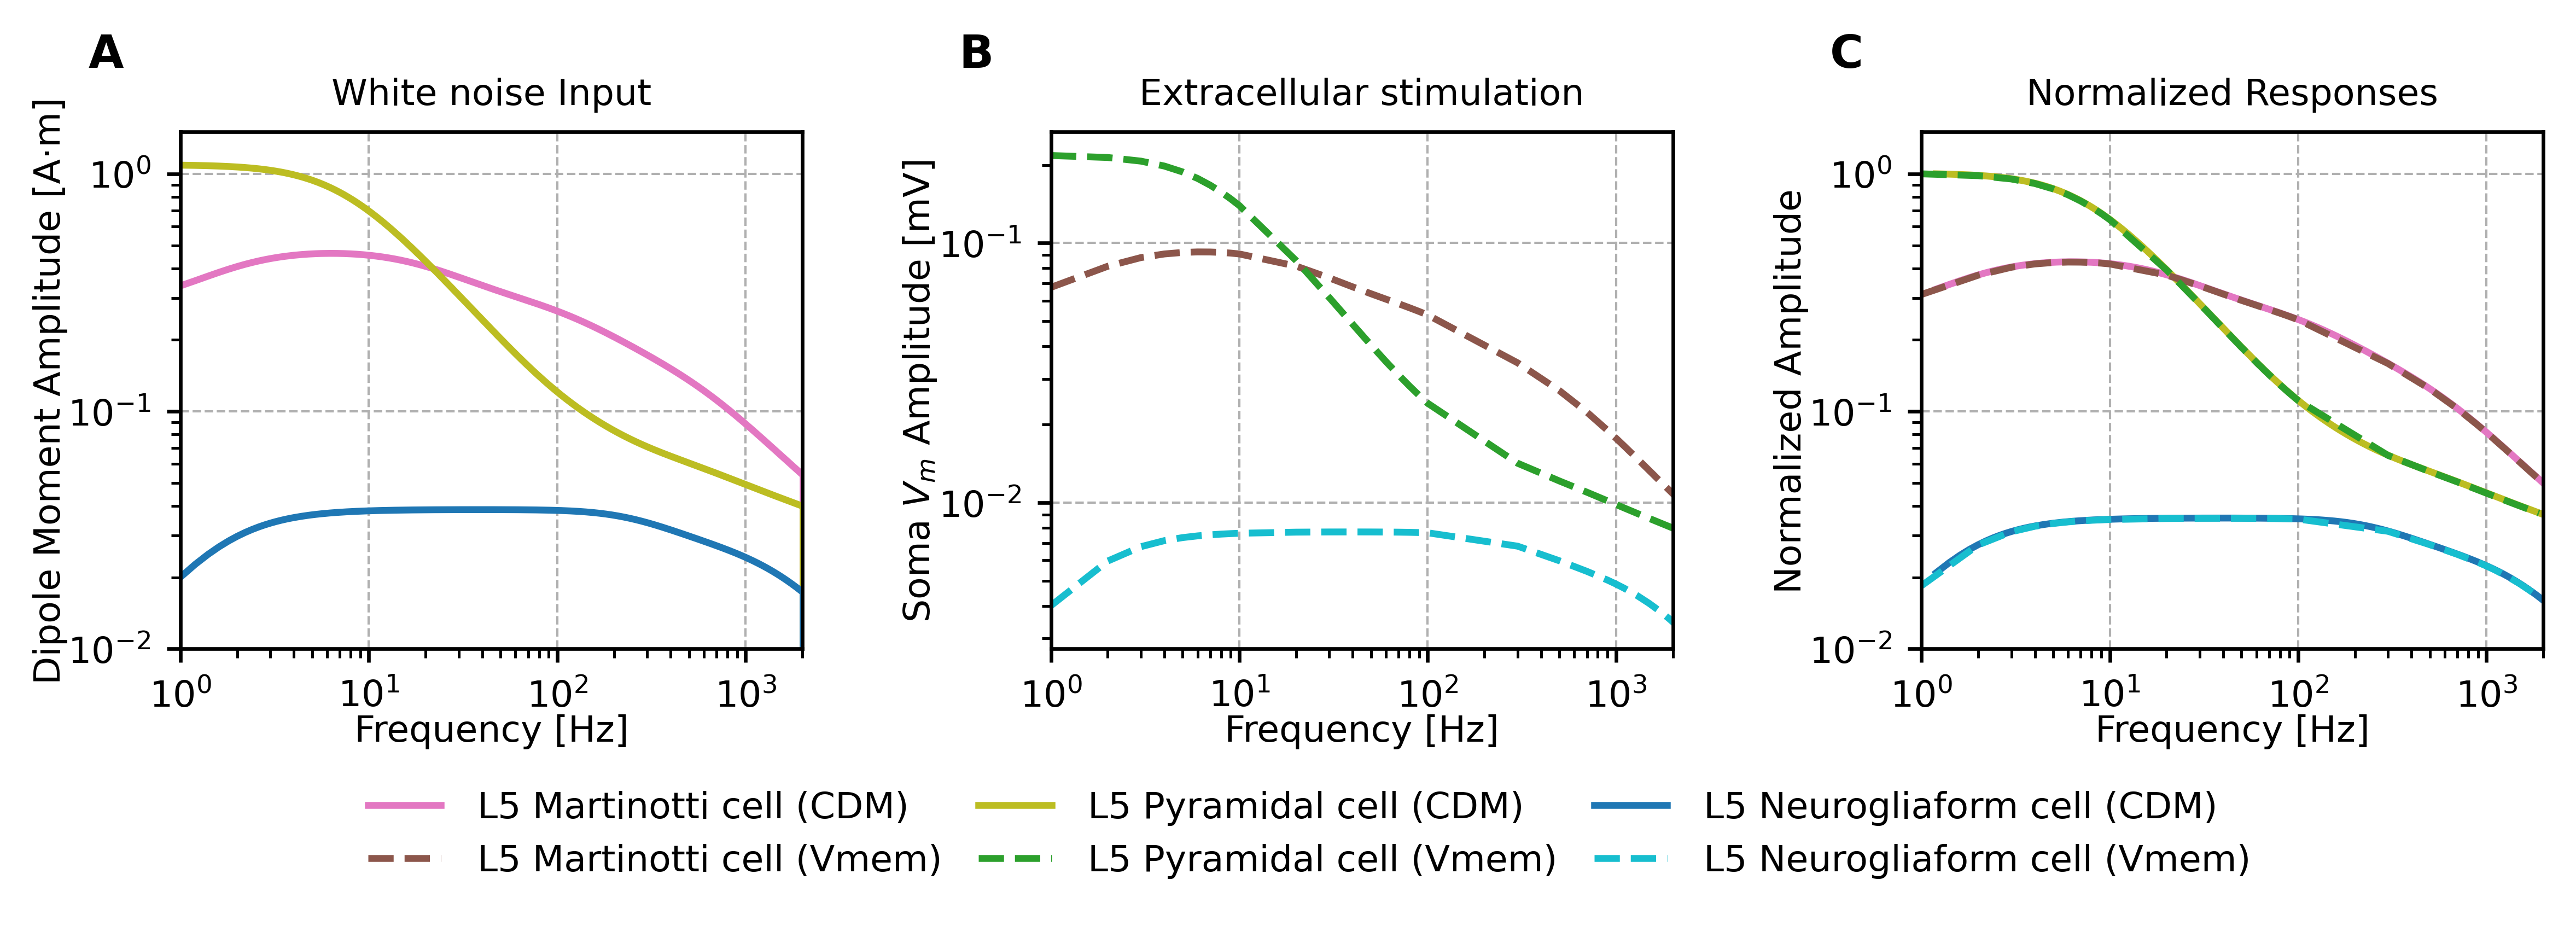

In [23]:
# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2.5))
fig.subplots_adjust(bottom=0.25, left=0.07, right=0.97, top=0.88, wspace=0.4)
colors_cdm = ["tab:pink", "tab:olive", "tab:blue"]
colors_vmem = ["tab:brown", "tab:green", "tab:cyan"]

# ---- Subplot A: CDM Amplitudes ----
i = 0
for label, (freqs_s, amp) in cdm_amp_dict.items():
    ax1.loglog(freqs_s, amp, lw=1.5, label=label, color=colors_cdm[i])
    i += 1

ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Dipole Moment Amplitude [A·m]")
ax1.set_title("White noise Input")
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.set_ylim(top=1.5, bottom=1e-2)
ax1.set_xlim(left=1, right=2000)
#ax1.legend(loc="upper right", fontsize='x-small')

# ---- Subplot B: Soma Vmem Amplitudes ----
i = 0
for label, data in soma_amp_dict.items():
    freqs = np.array(data["freq"])
    soma_vmem_amps = np.array(data["soma_vmem_amp"])
    ax2.loglog(freqs, soma_vmem_amps, lw=1.5, label=label, color=colors_vmem[i], linestyle='--')
    i += 1

ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel(r"Soma $V_m$ Amplitude [mV]")
ax2.set_title("Extracellular stimulation")
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.set_xlim(left=1, right=2000)
#ax2.legend(loc="upper right", fontsize='x-small')

# ---- Subplot C: Normalized Combined ----
# Get max for CDM
cdm_global_max = 0
for freqs_s, amp in cdm_amp_dict.values():
    freqs_s = np.array(freqs_s)
    mask = (freqs_s >= 1) & (freqs_s <= 2000)
    max_val = np.max(amp[mask])
    if max_val > cdm_global_max:
        cdm_global_max = max_val

# Plot normalized CDM
i = 0
for label, (freqs_s, amp) in cdm_amp_dict.items():
    freqs_s = np.array(freqs_s)
    mask = (freqs_s >= 1) & (freqs_s <= 2000)
    amp_norm = amp[mask] / cdm_global_max
    ax3.loglog(freqs_s[mask], amp_norm, lw=1.5, label=f"{label} (Dipole)", color=colors_cdm[i])
    i += 1

# Get max for soma
soma_global_max = 0
for data in soma_amp_dict.values():
    freqs = np.array(data["freq"])
    amps = np.array(data["soma_vmem_amp"])
    mask = (freqs >= 1) & (freqs <= 2000)
    max_val = np.max(amps[mask])
    if max_val > soma_global_max:
        soma_global_max = max_val

# Plot normalized Soma Vmem
i = 0
for label, data in soma_amp_dict.items():
    freqs = np.array(data["freq"])
    amps = np.array(data["soma_vmem_amp"])
    mask = (freqs >= 1) & (freqs <= 2000)
    amps_norm = amps[mask] / soma_global_max
    ax3.loglog(freqs[mask], amps_norm, lw=1.5, linestyle='--', label=f"{label} (Soma $V_m$)", color=colors_vmem[i])
    i += 1

ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylabel("Normalized Amplitude")
ax3.set_title("Normalized Responses")
ax3.grid(True, linestyle='--', linewidth=0.5)
ax3.set_xlim(left=1, right=2000)
ax3.set_ylim(bottom=1e-2, top=1.5)

legend_elements = []
cell_labels = list(cdm_amp_dict.keys())  # Assuming same order as color lists

# Creating legend elements
for i, label in enumerate(cell_labels):
    cdm_line = Line2D([0], [0], color=colors_cdm[i], lw=1.5, linestyle='-', label=f'{label} (CDM)')
    vmem_line = Line2D([0], [0], color=colors_vmem[i], lw=1.5, linestyle='--', label=f'{label} (Vmem)')
    legend_elements.extend([cdm_line, vmem_line])

# Add the legend underneath all subplots
fig.legend(handles=legend_elements,
           loc='lower center',
           ncol=len(cell_labels) , 
           bbox_to_anchor=(0.5, -0.07), 
           handletextpad=1.0,
           columnspacing=1.0,
           frameon=False)

mark_subplots(fig.axes)

# Save and show
fig.savefig("combined_cdm_soma_subplots.png", dpi=300, bbox_inches='tight')
plt.show()
